# Import Modules and CSV File

In [9]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from datetime import datetime
import re
import random
import gc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'axes.titleweight': 'bold',
          'axes.labelweight': 'bold',
          'xtick.labelsize':'xx-large',
          'xtick.major.size': 5.5,
          'ytick.labelsize':'xx-large',
          'ytick.major.size': 5.5,
          'axes.labelpad': 15.0,
          'grid.color': 'gray',
          'axes.edgecolor': 'black'}
pylab.rcParams.update(params)
plt.rcParams["patch.force_edgecolor"] = True

In [12]:
file = '/Users/charisameeker/Documents/Data/Iowa Liquor/iowa_liquor_clean1.9.csv'
df = pd.read_csv(file,
        parse_dates = ['date'],
        dtype = {'year':np.int16, 'month':np.int8, 'day':np.int8,
        'store_number':np.int16, 'county_number':np.int8, 'item_number':np.int32,
        'pack':np.int16, 'bottle_vol':np.int64, 'bottle_cost':np.float32,
        'state_bottle_retail':np.float32, 'bottles_sold':np.int16, 'sale':np.float32,
        'vol_sold':np.float32, 'bottles_sold':np.int16,
        'category':np.int32
        })

In [13]:
# These columns aren't useful for our machine models.
df.drop(['Unnamed: 0', 'store_location', 'coordinates', 'stores_subname'], axis=1, inplace=True)

In [14]:
df.dtypes

date                   datetime64[ns]
year                            int16
month                            int8
day                              int8
store_number                    int16
store_name                     object
address                        object
city                           object
zip_code                      float64
county_number                    int8
county                         object
category                        int32
category_name                  object
vendor_number                 float64
vendor_name                    object
item_number                     int32
item_description               object
pack                            int16
bottle_vol                      int64
bottle_cost                   float32
state_bottle_retail           float32
bottles_sold                    int16
sale                          float32
vol_sold                      float32
store_subname                  object
store_subnumber                object
dtype: objec

# 1. Missing Values

In [15]:
def nan_percentage(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
    missing_data['Missing Percent'] = missing_data['Missing Percent'].apply(lambda x: x * 100)
    print(missing_data[missing_data['Total'] > 0].round({'Missing Percent': 3}))
    
nan_percentage(df)

                   Total  Missing Percent
store_subnumber  8584472           68.179
store_subname    4290853           34.079
county             79178            0.629
category_name       8024            0.064
zip_code            2420            0.019
address             2376            0.019
city                2375            0.019
vendor_number          3            0.000
vendor_name            1            0.000


## Let's address these in descending order, and then the columns especially related to sales, which has many 0 values.

## 1.1 Our new columns store_subnumber and store_subname have many missing values. We cannot recover any of those values (or be sure they exist for every store).

In [16]:
df.store_subnumber.shape[0] - df.store_subnumber.str.isnumeric().sum()

9167469

In [17]:
df.query('store_subnumber == 100').shape[0]

0

### There are many non-numeric values, and no values of 100 (our standard NaN number). So we'll convert them to numerics then fill the NaNs with 100.

In [18]:
df['store_subnumber'] = pd.to_numeric(df['store_subnumber'], errors='coerce', downcast='integer')
df['store_subnumber'].dtype

dtype('float64')

In [19]:
df.store_subnumber = df.store_subnumber.fillna(100)

In [20]:
df.store_subnumber = df.store_subnumber.astype('int16')

### store_subname will be replaced with strings: 'nan'

In [21]:
df.store_subname = df.store_subname.fillna('nan')

## 1.2 The county_number and county columns still have unrecoverable information
## 1.3 category_name

In [22]:
df.county = df.county.fillna('nan')

In [23]:
df.category_name = df.category_name.fillna('nan')

## 1.4 The address column has one value that is able to be found and inserted by a quick query via a search engine.
## - Otherwise, the columns address, city, and coordinates are strings and so will have 'nan' inserted.

In [24]:
df.query('address.isna() & city.notna()', engine='python')

,date,year,month,day,store_number,store_name,address,city,zip_code,county_number,...,item_description,pack,bottle_vol,bottle_cost,state_bottle_retail,bottles_sold,sale,vol_sold,store_subname,store_subnumber
11755302,2017-06-22,2017,6,22,9932,"3-oaks distillery, llc",NaN,dubuque,520020.0,31,...,3-oaks distillery whiskey,12,750,21.6,32.400002,1,388.799988,0.75,nan,100


In [25]:
df.address[11755302] = '23039 Pfeiler Rd'

<ipython-input-25-33951e80f189>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.address[11755302] = '23039 Pfeiler Rd'


In [26]:
df.sale.isna().sum()

0

In [27]:
df.address = df.address.fillna('nan')
df.city = df.city.fillna('nan')
df.category_name = df.category_name.fillna('nan')
df.zip_code = df.zip_code.fillna(100)

## 1.5 sale-related Columns:
 - state_bottle_retail
 - bottle_cost
 - sale
### I converted the NaN values of the sale-related columns to 0. They cannot stay 0 because they will be subject to mathematical operations. The median is a safe bet, especially because they constitute far less than 1% of the data.

In [28]:
print(df.query('state_bottle_retail == 0 | bottle_cost == 0 | sale == 0').shape[0],
'rows of the above contain zero. They were NaN before converted to 0.',
'\n', df.query('bottle_cost == 0 & sale == 0').shape[0], 'rows contain NaNs for all three columns: state_bottle_retail, bottle_cost, sale.',
'\n\t-', df.query('state_bottle_retail == 0').shape[0], 'rows are state_bottle_retail.',
'\n\t-', df.query('bottle_cost == 0').shape[0], 'rows are bottle_cost.',
'\n\t-', df.query('state_bottle_retail == 0 & bottle_cost == 0').shape[0], 'rows are both state_bottle_retail and bottle_cost.'
'\n', df.query('sale == 0').shape[0], 'rows are sale alone, with',
      df.query('sale == 0 & bottle_cost != 0').shape[0],'more than the other factors.')

4316 rows of the above contain zero. They were NaN before converted to 0. 
 3094 rows contain NaNs for all three columns: state_bottle_retail, bottle_cost, sale. 
	- 3094 rows are state_bottle_retail. 
	- 3094 rows are bottle_cost. 
	- 3094 rows are both state_bottle_retail and bottle_cost.
 4316 rows are sale alone, with 1222 more than the other factors.


In [29]:
# Convert to NaN
df.state_bottle_retail = df.state_bottle_retail.replace(0, np.nan)
df.bottle_cost = df.bottle_cost.replace(0, np.nan)
df.sale = df.sale.replace(0, np.nan)

In [30]:
imr = SimpleImputer(strategy='median')
imr = imr.fit(df[['state_bottle_retail']])
df.state_bottle_retail = imr.transform(df[['state_bottle_retail']]).ravel()

In [31]:
imr = SimpleImputer(strategy='median')
imr = imr.fit(df[['bottle_cost']])
df.bottle_cost = imr.transform(df[['bottle_cost']]).ravel()

In [32]:
imr = SimpleImputer(strategy='median')
imr = imr.fit(df[['sale']])
df.sale = imr.transform(df[['sale']]).ravel()

## 1.6 vendor_name and vendor_number

In [33]:
pd.set_option('display.max_columns', None)
df.query('vendor_number.isna()', engine='python')

,date,year,month,day,store_number,store_name,address,city,zip_code,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_vol,bottle_cost,state_bottle_retail,bottles_sold,sale,vol_sold,store_subname,store_subnumber
10188726,2016-10-17,2016,10,17,2190,"central city liquor, inc.",1460 2nd ave,des moines,50314.0,77,polk,1011300,single barrel bourbon whiskies,NaN,reservoir distillery,916456,reservoir bourbon whiskey,6,750,45.00,67.500000,5,405.000000,3.75,nan,100
10188727,2016-10-17,2016,10,17,2190,"central city liquor, inc.",1460 2nd ave,des moines,50314.0,77,polk,1091100,american distilled spirit specialty,NaN,reservoir distillery,927565,reservoir wheat whiskey,6,750,45.00,67.500000,3,405.000000,2.25,nan,100
11174263,2017-03-22,2017,3,22,2556,hy-vee wine and spirits,2608 e. central avenue,estherville,51334.0,32,emmet,100,nan,NaN,NaN,905433,laphroaig quarter cask,6,750,4.17,47.240002,1,283.440002,0.75,estherville,100


In [34]:
df.vendor_number = df.vendor_number.fillna(5)
df.vendor_name = df.vendor_name.replace(np.nan, 'nan')

In [35]:
df[df.vendor_name.str.contains('reservoir')]

,date,year,month,day,store_number,store_name,address,city,zip_code,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_vol,bottle_cost,state_bottle_retail,bottles_sold,sale,vol_sold,store_subname,store_subnumber
10188726,2016-10-17,2016,10,17,2190,"central city liquor, inc.",1460 2nd ave,des moines,50314.0,77,polk,1011300,single barrel bourbon whiskies,5.0,reservoir distillery,916456,reservoir bourbon whiskey,6,750,45.0,67.5,5,405.0,3.75,nan,100
10188727,2016-10-17,2016,10,17,2190,"central city liquor, inc.",1460 2nd ave,des moines,50314.0,77,polk,1091100,american distilled spirit specialty,5.0,reservoir distillery,927565,reservoir wheat whiskey,6,750,45.0,67.5,3,405.0,2.25,nan,100


### Ideally, because two of the three rows missing a vendor number have a vendor name, we would be able to derive those numbers from the vendor name by finding another row with the same vendor name ('reservoir bourbon whiskey') and impute the corresponding vendor number. Unfortunately, there is no other row with such a vendor name. The three missing values will stay missing. <br>
### 5 will be our secondary NaN number, as used above.

## Confirm No NaNs and Minimize dtypes

In [36]:
nan_percentage(df)

Empty DataFrame
Columns: [Total, Missing Percent]
Index: []


In [37]:
# numbers
df.zip_code = df.zip_code.astype('int16')
df.vendor_number = df.vendor_number.astype('int16')

# object/string
df.store_name = df.store_name.astype('str')
df.address = df.address.astype('str')
df.city = df.city.astype('str')
df.county = df.county.astype('str')
df.category_name = df.category_name.astype('str')
df.vendor_name = df.vendor_name.astype('str')
df.item_description = df.item_description.astype('str')
df.store_subname = df.store_subname.astype('str')

In [38]:
df.dtypes

date                   datetime64[ns]
year                            int16
month                            int8
day                              int8
store_number                    int16
store_name                     object
address                        object
city                           object
zip_code                        int16
county_number                    int8
county                         object
category                        int32
category_name                  object
vendor_number                   int16
vendor_name                    object
item_number                     int32
item_description               object
pack                            int16
bottle_vol                      int64
bottle_cost                   float32
state_bottle_retail           float32
bottles_sold                    int16
sale                          float32
vol_sold                      float32
store_subname                  object
store_subnumber                 int16
dtype: objec

### Memory

In [39]:
print('Memory Usage (Deep=True) (GB):',
      np.round(df.memory_usage(deep=True).sum() / 10 ** 9, decimals=2),
    '\nMemory Usage (Deep=False) (GB):',
      np.round(df.memory_usage(deep=False).sum() / 10 ** 9, decimals=2))

Memory Usage (Deep=True) (GB): 7.93 
Memory Usage (Deep=False) (GB): 1.52


# 2. EDA

## 2.1 Preparing for FB Prophet Analysis
### I planned to perform this in a different notebook file, but after three days of running my laptop, it never resolved anything. I just don't have the computing power to use FBProphet.

In [30]:
proph_d = {'ds': df.date, 'y': df.sale}
df_prophet = pd.DataFrame(data=proph_d)
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12591077 entries, 0 to 12591076
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   ds      datetime64[ns]
 1   y       float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 144.1 MB


In [31]:
#file = '/.../Data/iowa_liquor_prophet.csv'
#df_prophet.to_csv(file, index=False)

## 2.2 Sales

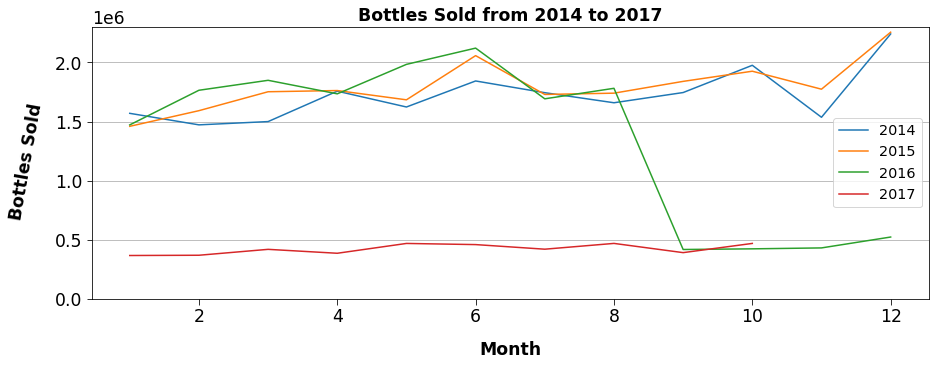

In [94]:
df.query('year == 2014').groupby('month').bottles_sold.sum().plot(label='2014')
df.query('year == 2015').groupby('month').bottles_sold.sum().plot(label='2015')
df.query('year == 2016').groupby('month').bottles_sold.sum().plot(label='2016')
df.query('year == 2017').groupby('month').bottles_sold.sum().plot(label='2017')
plt.title('Bottles Sold from 2014 to 2017')
plt.xlabel('Month'), plt.xticks(rotation=0)
plt.ylabel('Bottles Sold',rotation=80,labelpad=20), plt.legend()
plt.ylim(0, 2.3 * 10**6)
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

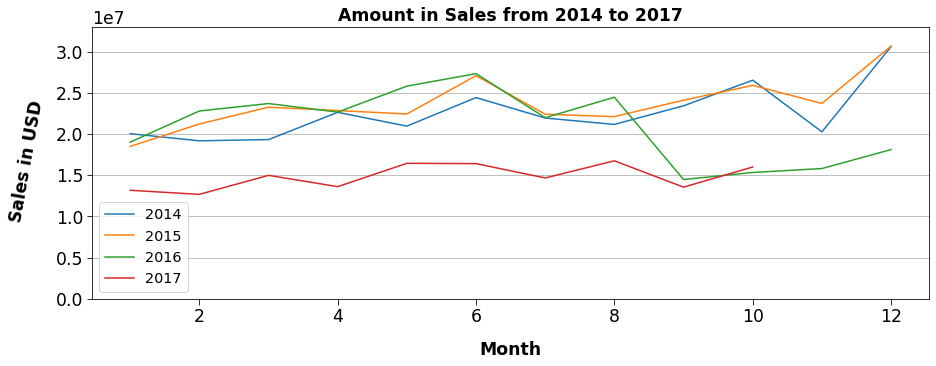

In [85]:
df.query('year == 2014').groupby('month').sale.sum().plot(label='2014')
df.query('year == 2015').groupby('month').sale.sum().plot(label='2015')
df.query('year == 2016').groupby('month').sale.sum().plot(label='2016')
df.query('year == 2017').groupby('month').sale.sum().plot(label='2017')
plt.title('Amount in Sales from 2014 to 2017')
plt.xlabel('Month'), plt.xticks(rotation=0)
plt.ylabel('Sales in USD',rotation=80,labelpad=20), plt.legend()
plt.ylim(0, 3.3 * 10**7)
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

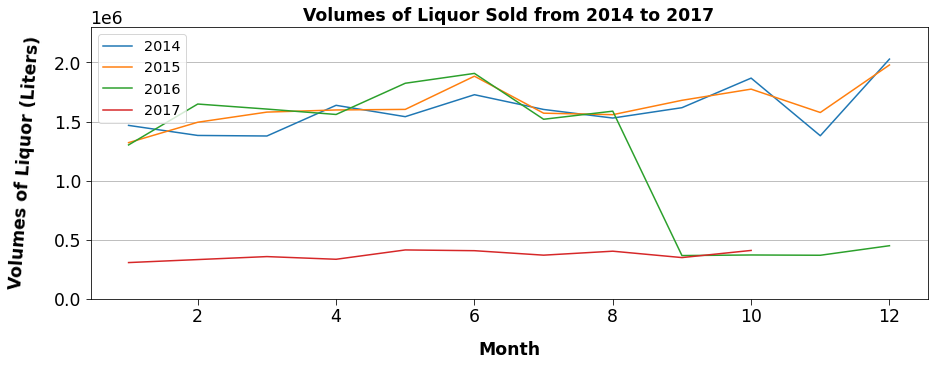

In [89]:
df.query('year == 2014').groupby('month').vol_sold.sum().plot(label='2014')
df.query('year == 2015').groupby('month').vol_sold.sum().plot(label='2015')
df.query('year == 2016').groupby('month').vol_sold.sum().plot(label='2016')
df.query('year == 2017').groupby('month').vol_sold.sum().plot(label='2017')
plt.title('Volumes of Liquor Sold from 2014 to 2017')
plt.xlabel('Month'), plt.xticks(rotation=0)
plt.ylabel('Volumes of Liquor (Liters)',rotation=86,labelpad=20), plt.legend()
plt.ylim(0, 2.3 * 10**6)
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

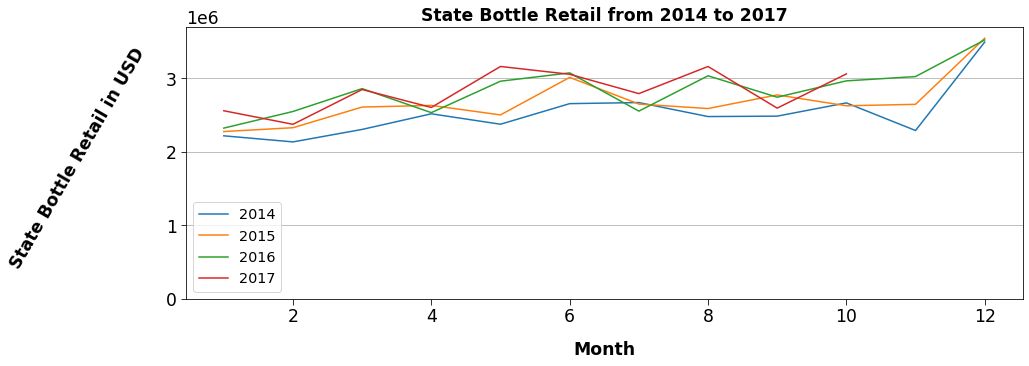

In [90]:
df.query('year == 2014').groupby('month').state_bottle_retail.sum().plot(label='2014')
df.query('year == 2015').groupby('month').state_bottle_retail.sum().plot(label='2015')
df.query('year == 2016').groupby('month').state_bottle_retail.sum().plot(label='2016')
df.query('year == 2017').groupby('month').state_bottle_retail.sum().plot(label='2017')
plt.title('State Bottle Retail from 2014 to 2017')
plt.xlabel('Month'), plt.xticks(rotation=0)
plt.ylabel('State Bottle Retail in USD',rotation=60,labelpad=80), plt.legend()
plt.ylim(0, 3.7 * 10**6)
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

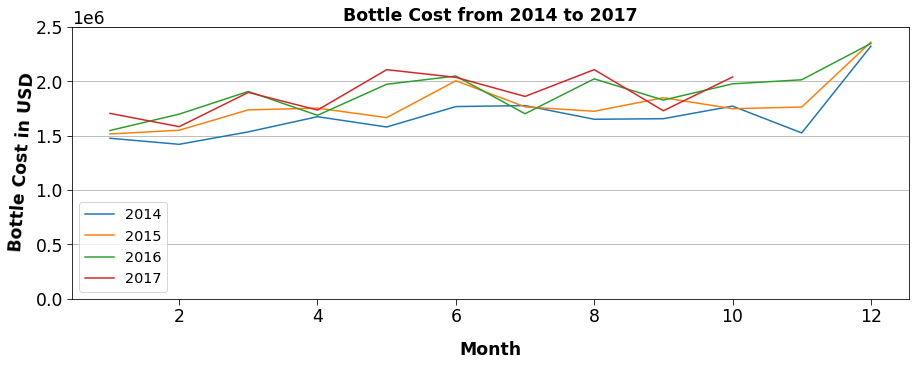

In [91]:
df.query('year == 2014').groupby('month').bottle_cost.sum().plot(label='2014')
df.query('year == 2015').groupby('month').bottle_cost.sum().plot(label='2015')
df.query('year == 2016').groupby('month').bottle_cost.sum().plot(label='2016')
df.query('year == 2017').groupby('month').bottle_cost.sum().plot(label='2017')
plt.title('Bottle Cost from 2014 to 2017')
plt.xlabel('Month'), plt.xticks(rotation=0)
plt.ylabel('Bottle Cost in USD',rotation=86,labelpad=4), plt.legend()
plt.ylim(0, 2.5 * 10**6)
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')

### This data is odd because, while prices for 2016 and 2017 stayed roughtly the same as the previous years, the amount of liquor purchases dropped significantly onward from August 2016. A quick search online produces some plausible factors such as strict-yet-changing liquor laws and the burgeoning of micro-breweries.
#### cf. https://qctimes.com/news/opinion/editorial/editorial-iowa-clings-to-anti-business-liquor-laws/article_655286e2-047e-597a-83b4-d230c7cc5ec3.html
#### cf. https://siouxcityjournal.com/news/opinion/editorial/our-opinion-its-time-to-look-at-iowas-alcohol-laws/article_1ede3cb4-227b-5f22-89b5-d504cfb73de1.html

## Categories

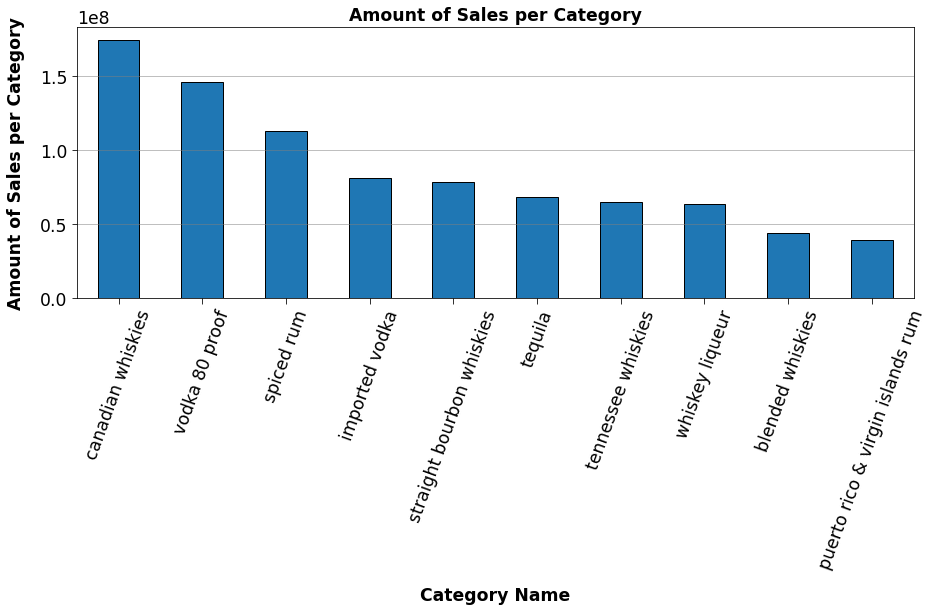

In [97]:
df1 = df.groupby('category_name').sale.sum().sort_values(ascending=False)
df1.head(10).plot.bar()
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')
_ = plt.xticks(rotation=70)
_ = plt.title('Amount of Sales per Category')
_ = plt.xlabel('Category Name')
_ = plt.ylabel('Amount of Sales per Category')

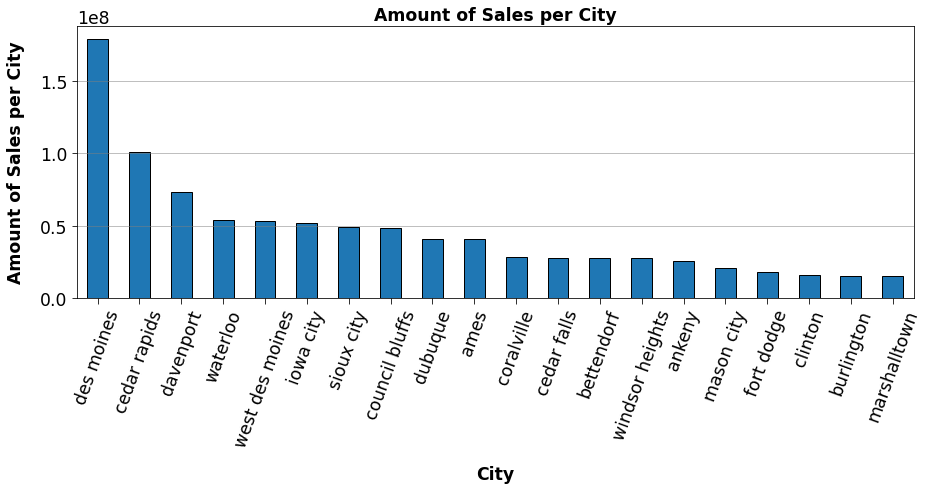

In [102]:
df2 = df.groupby('city').sale.sum().sort_values(ascending=False)
df2.head(20).plot.bar()
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')
_ = plt.xticks(rotation=70)
_ = plt.title('Amount of Sales per City')
_ = plt.xlabel('City')
_ = plt.ylabel('Amount of Sales per City')

### Amount of sales per city resembles a Pareto distribution. Here are the population sizes of the top three cities, and of Ames (a middle value) as of 2018:
 - Des Moines: 216,853
 - Cedar Rapids: 133,174
 - Davenport: 102,085
 - Waterloo: 67,798
 - Ames: 67,154

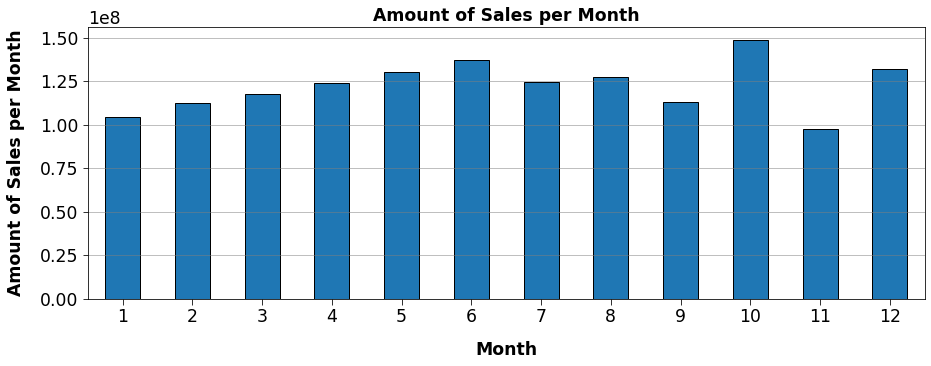

In [105]:
df_month = df.groupby('month').sale.sum()
df_month.plot.bar()
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')
_ = plt.xticks(rotation=0)
_ = plt.title('Amount of Sales per Month')
_ = plt.xlabel('Month')
_ = plt.ylabel('Amount of Sales per Month')

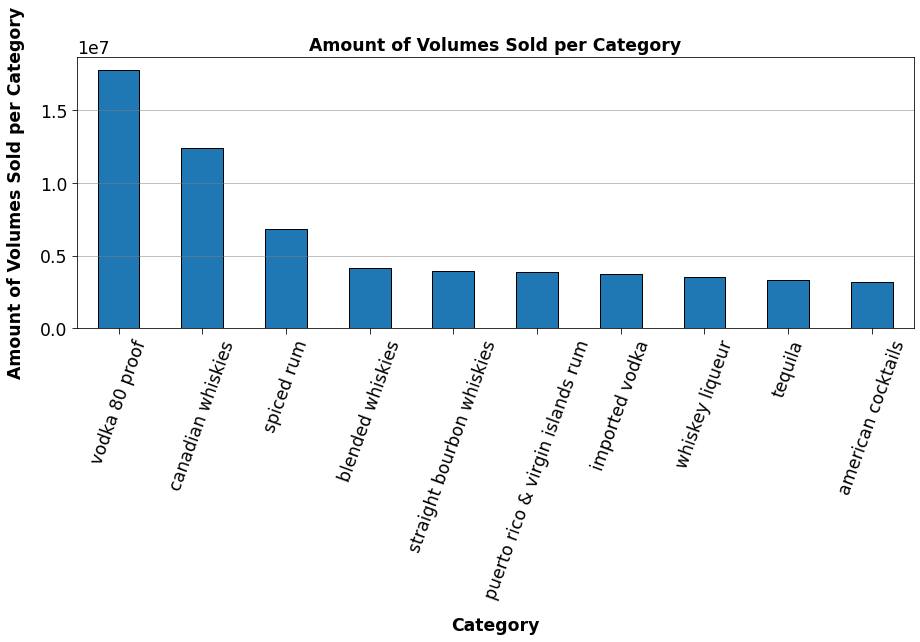

In [104]:
df_vol = df.groupby('category_name').vol_sold.sum().sort_values(ascending=False)
df_vol.head(10).plot.bar()
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')
_ = plt.xticks(rotation=70)
_ = plt.title('Amount of Volumes Sold per Category')
_ = plt.xlabel('Category')
_ = plt.ylabel('Amount of Volumes Sold per Category')

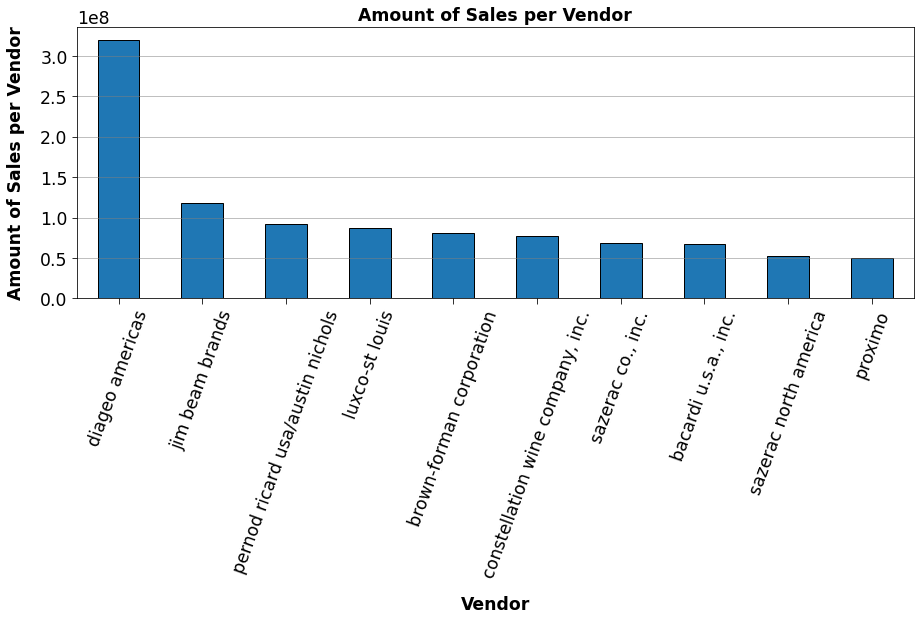

In [106]:
df_ven = df.groupby('vendor_name').sale.sum().sort_values(ascending=False)
df_ven.head(10).plot.bar()
_ = plt.grid(color='grey', linestyle='-', linewidth=.5, axis='y')
_ = plt.xticks(rotation=70)
_ = plt.title('Amount of Sales per Vendor')
_ = plt.xlabel('Vendor')
_ = plt.ylabel('Amount of Sales per Vendor')

## Sales Distribution
### Let's use boxcox to cram it into a more normal distribution and compare the results, especially the outliers.

In [41]:
fitted_data, fitted_lambda = stats.boxcox(df.sale)

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:908: RuntimeWarning: overflow encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)


In [42]:
df.insert(23, 'fd', fitted_data)

#### Normal distribution

Max value: $254,100.0 
Mean of sales: $114.48 
Standard deviation of sales: $377.75


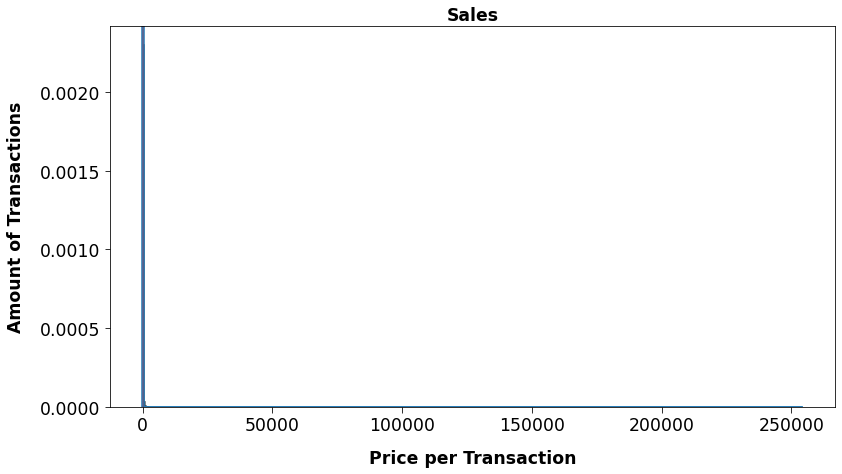

In [61]:
_ = plt.figure(figsize=(13, 7))
_ = sns.distplot(df['sale'], bins=600)
_ = plt.axvline(np.mean(df.sale), c='r')
_ = plt.axvline(np.mean(df.sale) + np.std(df.sale))
_ = plt.axvline(np.mean(df.sale) - np.std(df.sale))
_ = plt.title('Sales')
_ = plt.xlabel('Price per Transaction')
_ = plt.ylabel('Amount of Transactions')

print(f'Max value: ${max(df.sale):,} \n\
Mean of sales: ${round(np.mean(df.sale), 2)} \n\
Standard deviation of sales: ${round(np.std(df.sale), 2)}')

#### Wow! Positive outlier values are so extreme that they obscure our view of most of the data. Let's limit the amount of sales we graph to 300 USD. Yet even with such a limitation, the blue lines representing one standard deviation on either side are extreme. We'll explore the outlier values below.

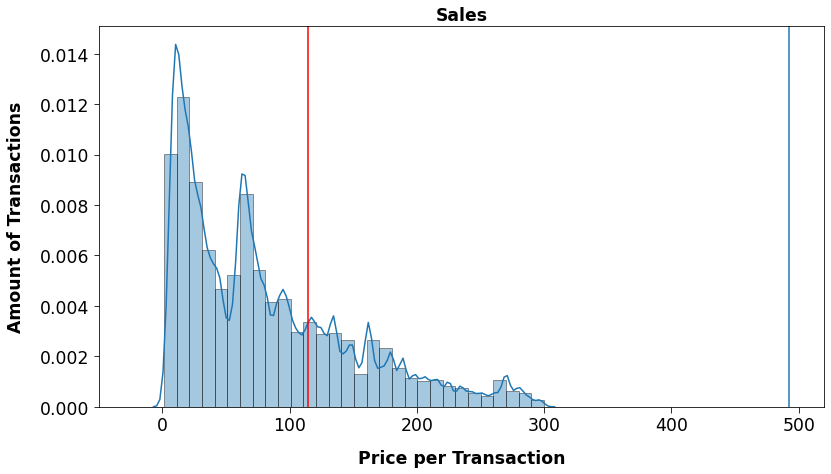

In [65]:
_ = plt.figure(figsize=(13, 7))
_ = plt.xlim(-50, 520)
_ = sns.distplot(df.query('sale < 300')['sale'], bins=30)
_ = plt.axvline(np.mean(df.sale), c='r')
_ = plt.axvline(np.mean(df.sale) + np.std(df.sale))
_ = plt.axvline(np.mean(df.sale) - np.std(df.sale))
_ = plt.title('Sales')
_ = plt.xlabel('Price per Transaction')
_ = plt.ylabel('Amount of Transactions')

#### It has a tail to the left. Let's see if our fitted data looks as skewed.

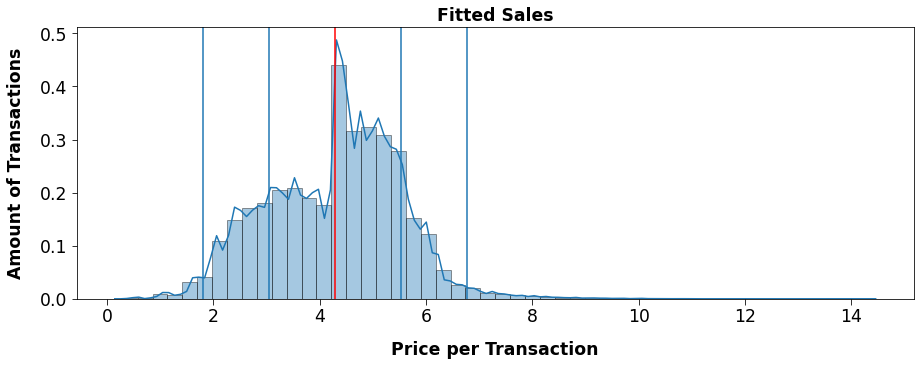

In [59]:
_ = sns.distplot(fitted_data)
_ = plt.axvline(np.mean(fitted_data), c='r')
_ = plt.axvline(np.mean(fitted_data) + np.std(fitted_data))
_ = plt.axvline(np.mean(fitted_data) + 2 * np.std(fitted_data))
_ = plt.axvline(np.mean(fitted_data) - np.std(fitted_data))
_ = plt.axvline(np.mean(fitted_data) - 2 * np.std(fitted_data))
_ = plt.title('Fitted Sales')
_ = plt.xlabel('Price per Transaction')
_ = plt.ylabel('Amount of Transactions')

### Outliers

In [67]:
print(f'Let\'s see about the tails. \n\
Excess kurtosis of normal distribution (should be 0): {round(stats.kurtosis(df.sale), 2):,} \n\
Fitted Data: {round(stats.kurtosis(fitted_data), 2)}')

Let's see about the tails. 
Excess kurtosis of normal distribution (should be 0): 44,774.07 
Fitted Data: 0.2


In [41]:
print(f'Coefficient of Variation: {round(stats.variation(df.sale), 2)} \n\
Fitted Data: {round(stats.variation(fitted_data), 2)}')

Coefficient of Variation: 3.299999952316284 
Fitted Data: 0.28999999165534973


In [70]:
# round with python or np don't work
print(f'Coefficient of Variation: {np.round(stats.variation(df.sale), decimals=2)} \n\
Fitted Data: {np.round(stats.variation(fitted_data), decimals=2)}')

Coefficient of Variation: 3.299999952316284 
Fitted Data: 0.28999999165534973


In [43]:
print(f'Mean: {round(df.sale.mean(), 2)} \n \
STD: {round(np.std(df.sale), 2)}\n \
The STD being larger than the mean shows that the data has immense spread. \n\n\
Fitted Data\n\
\t Mean: {round(fitted_data.mean(), 2)} \n\
\t STD: {round(np.std(fitted_data), 2)}')

Mean: 114.48 
 STD: 377.75
 The STD being larger than the mean shows that the data has immense spread. 

Fitted Data
	 Mean: 4.28000020980835 
	 STD: 1.2400000095367432


In [44]:
Q1 = df.sale.quantile(0.25)
Q3 = df.sale.quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR
print(f'Q1: {round(Q1, 2)} \n Q3: {round(Q3, 2)} \n IQR: {round(IQR, 2)} \n\
Upper: {round(upper, 2)}, \n Lower: {round(lower, 2)}')

# fitted data
Q1 = np.quantile(fitted_data, .25)
Q2 = np.quantile(fitted_data, .75)
# Q1 = fitted_data.quantile(0.25)
# Q3 = fitted_data.quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR
print(f'\nFitted Data: \n\
Q1: {round(Q1, 2)} \n Q3: {round(Q3, 2)} \n IQR: {round(IQR, 2)} \n\
Upper: {round(upper, 2)}, \n Lower: {round(lower, 2)}')

Q1: 25.48 
 Q3: 132.72 
 IQR: 107.24 
Upper: 293.58, 
 Lower: -135.38

Fitted Data: 
Q1: 3.36 
 Q3: 132.72 
 IQR: 129.36 
Upper: 326.77, 
 Lower: -190.69


In [56]:
std_pos = df.sale[df.sale > (np.mean(df.sale + (2 * np.std(df.sale))))].count()
std_pos_fd = df.fd[df.fd > (np.mean(df.fd + (2 * np.std(df.fd))))].count()
print(f'Instances Two STDs above: {std_pos:,} \n\
Fitted Data: {std_pos_fd:,}')

Instances Two STDs above: 116,323 
Fitted Data: 221,282


#### Oddly enough, the fitted data has almost twice as many outliers.

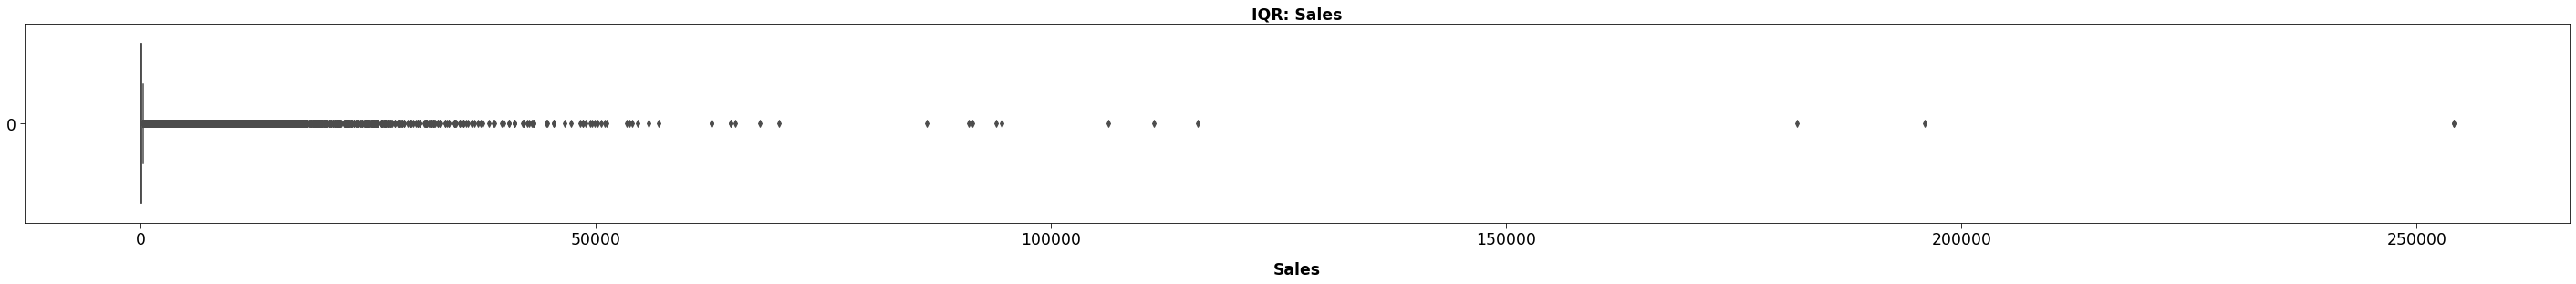

In [59]:
_ = plt.figure(figsize=(50, 4))
_ = sns.boxplot(data=df.sale, orient='h', color='cyan')
_ = plt.title('IQR: Sales')
_ = plt.xlabel('Sales')

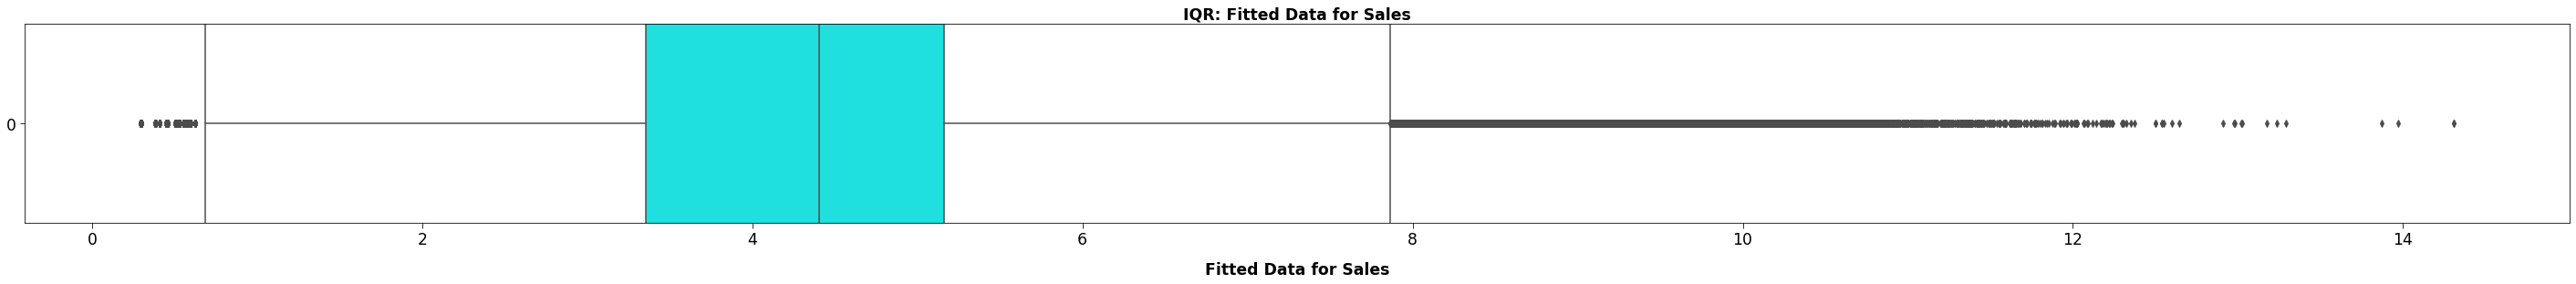

In [71]:
_ = plt.figure(figsize=(50, 4))
_ = sns.boxplot(data=fitted_data, orient='h', color='cyan', width = 8)
_ = plt.title('IQR: Fitted Data for Sales')
_ = plt.xlabel('Fitted Data for Sales')

#### Let's make the figure twice as long (100, 4).

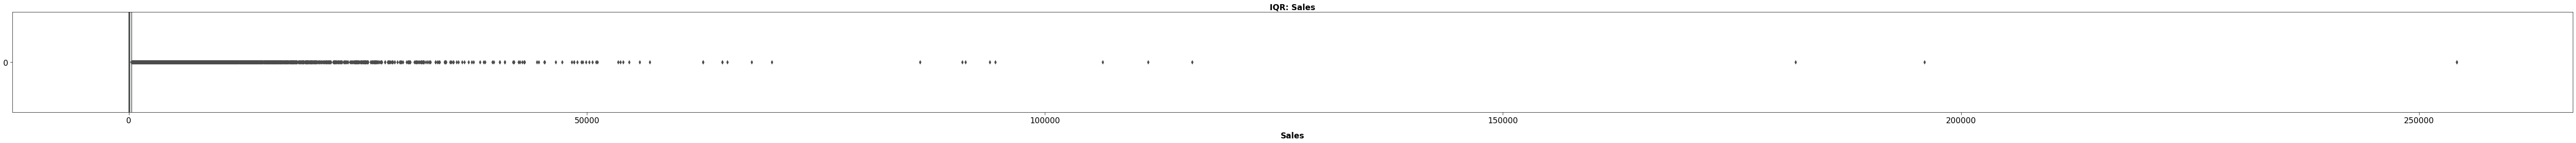

In [61]:
_ = plt.figure(figsize=(100, 4))
_ = sns.boxplot(data=df.sale, orient='h', color='cyan', width = 8)
_ = plt.title('IQR: Sales')
_ = plt.xlabel('Sales')

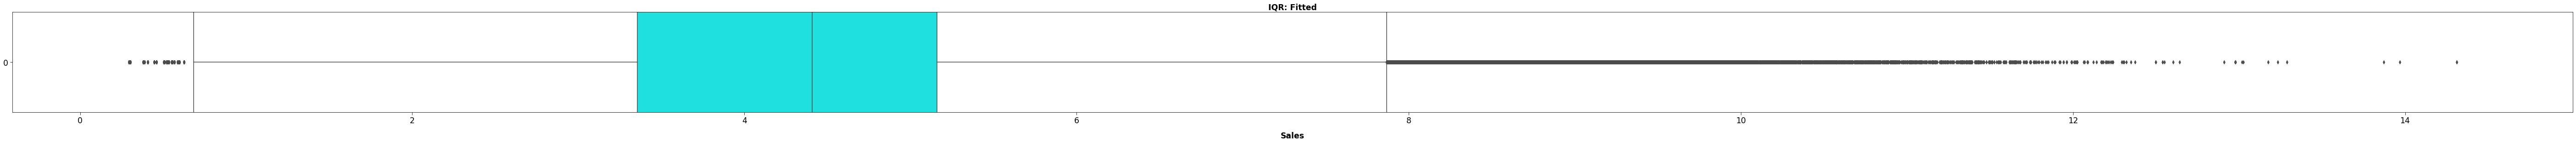

In [63]:
_ = plt.figure(figsize=(100, 4))
_ = sns.boxplot(data=df.fd, orient='h', color='cyan', width = 8)
_ = plt.title('IQR: Fitted')
_ = plt.xlabel('Sales')

## Back to Sales
### Unsurprisingly, a correlation matrix doesn't teach us much.

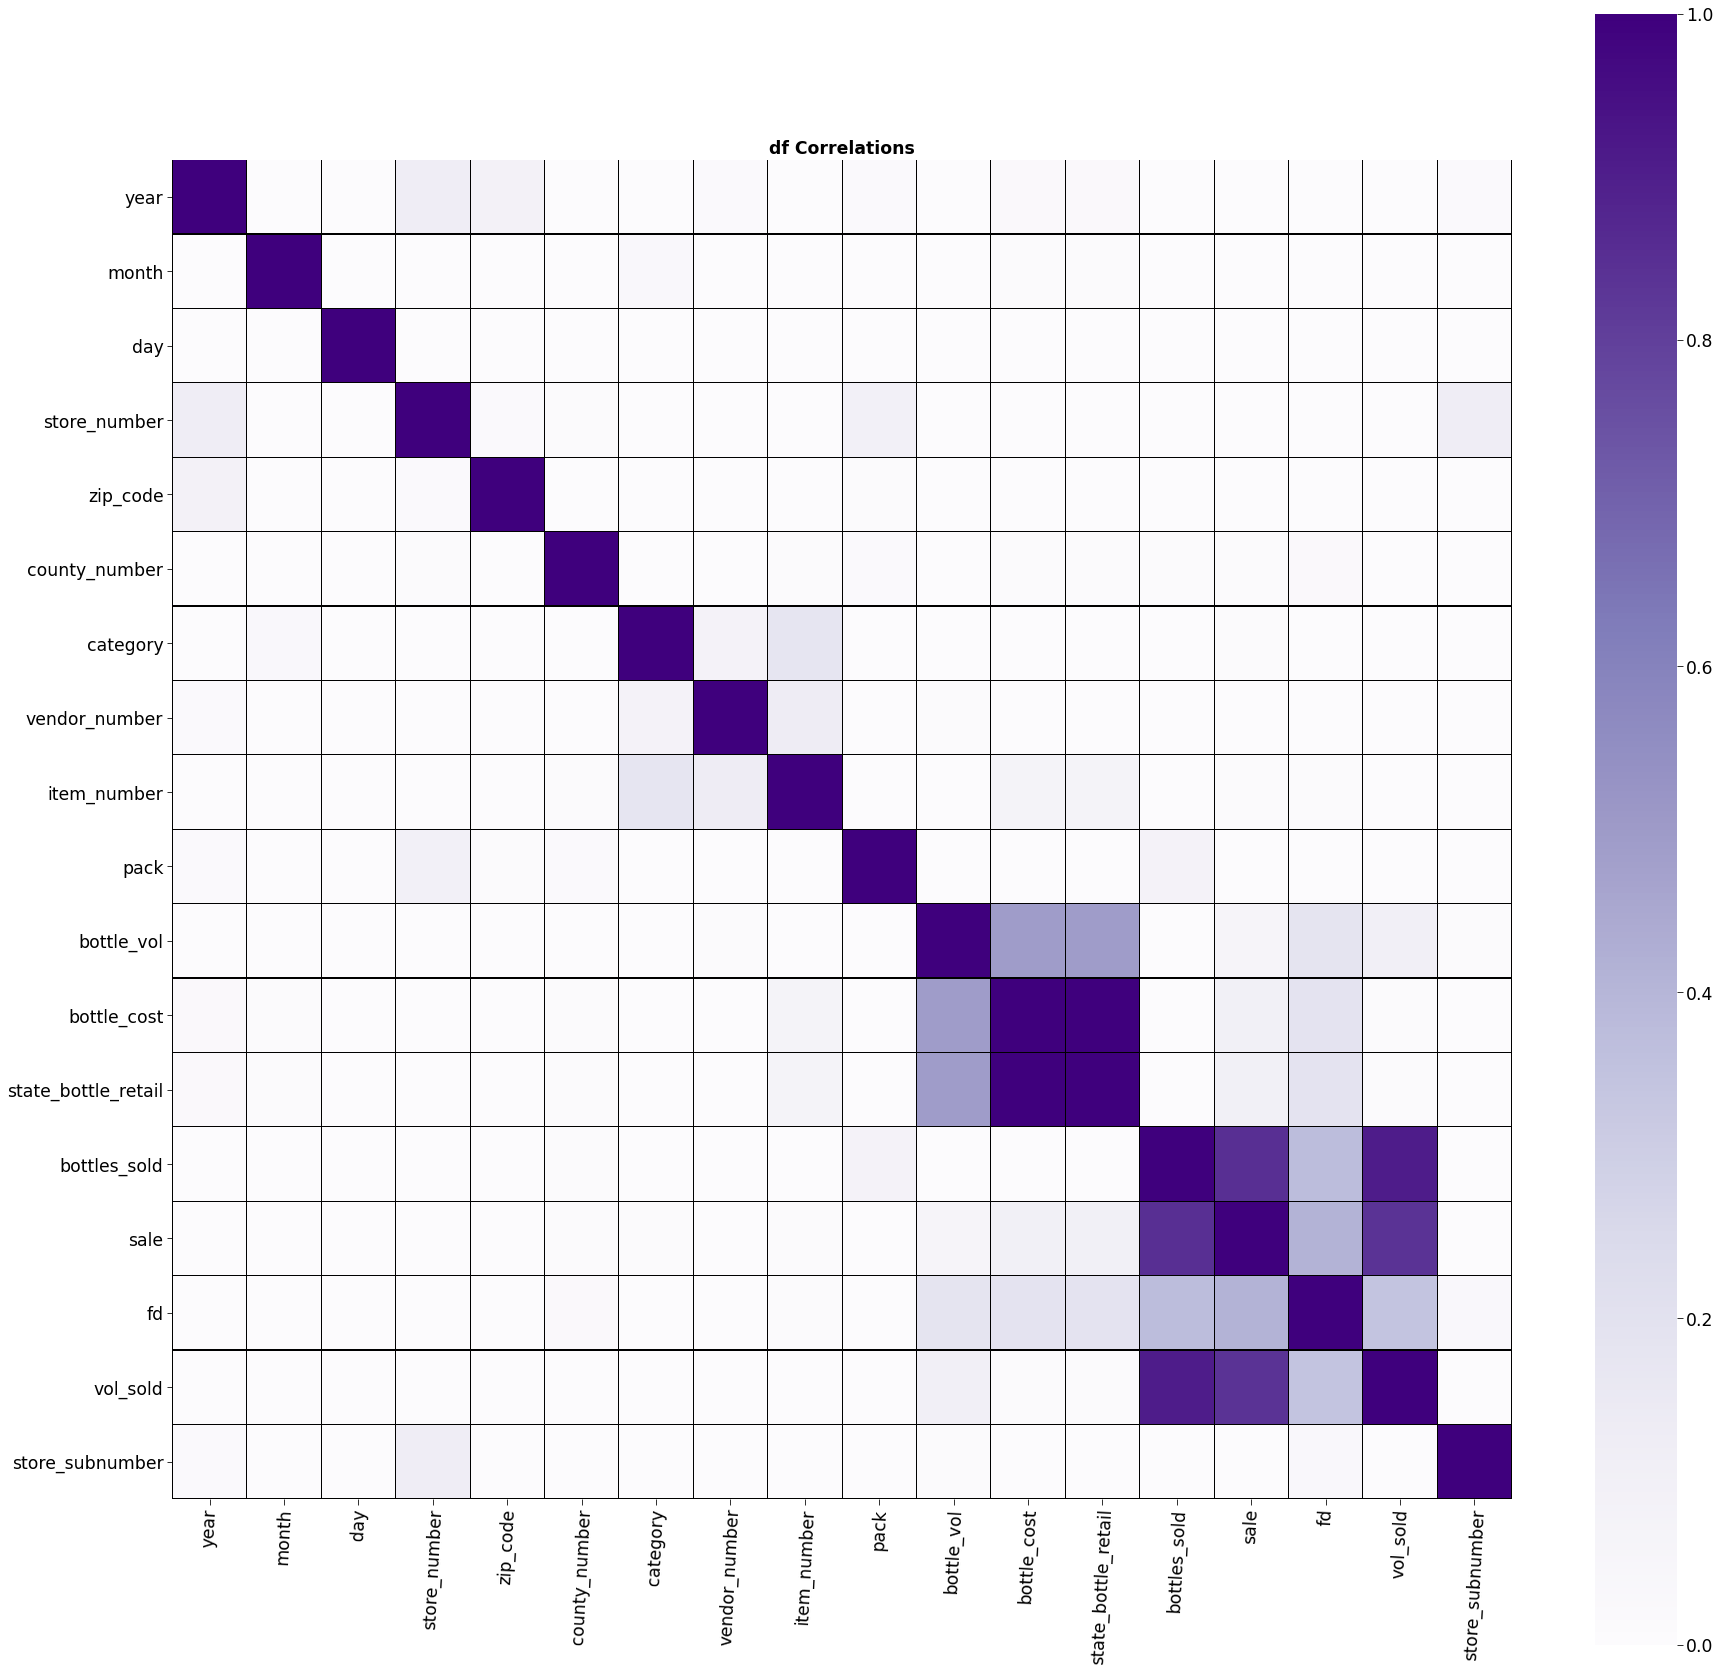

In [64]:
_ = plt.figure(figsize=(30, 30))
_ = sns.heatmap(df.corr(),square=True,vmin=0, vmax=1,cmap='Purples',linewidths=0.1,linecolor='k')
_ = plt.title('df Correlations')
_ = plt.xticks(rotation=87)

In [66]:
import ppscore as pps
matrix_df = pps.matrix(df.copy())[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/s

In [70]:
matrix_df.head()

x,address,bottle_cost,bottle_vol,bottles_sold,category,category_name,city,county,county_number,date,day,fd,item_description,item_number,month,pack,sale,state_bottle_retail,store_name,store_number,store_subname,store_subnumber,vendor_name,vendor_number,vol_sold,year,zip_code
y,,,,,,,,,,,,,,,,,,,,,,,,,,,
address,1.0,0.000883,0.00000,0.000000,0.000000,0.000000,0.245478,0.110806,0.108388,0.002641,0.0,0.002807,0.001518,0.002445,0.0,0.000000,0.002852,0.001306,0.456492,0.907786,0.246515,0.112912,0.000000,0.000000,0.000015,0.0,0.314844
bottle_cost,0.0,1.000000,0.07017,0.000000,0.156708,0.163503,0.000000,0.000000,0.000000,0.000000,0.0,0.351437,0.433387,0.804067,0.0,0.087092,0.347231,0.991994,0.000000,0.000000,0.000000,0.000000,0.104753,0.101491,0.000000,0.0,0.000000
bottle_vol,0.0,0.530030,1.00000,0.014947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.254720,0.261852,0.874833,0.0,0.495172,0.255513,0.541892,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.739809,0.0,0.000000
bottles_sold,0.0,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.358404,0.000000,0.000000,0.0,0.000000,0.357024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.793573,0.0,0.000000
category,0.0,0.300942,0.00000,0.000000,1.000000,0.983644,0.000000,0.000000,0.000000,0.000000,0.0,0.088104,0.780095,0.774543,0.0,0.000000,0.088869,0.326778,0.000000,0.000000,0.000000,0.000000,0.100716,0.113587,0.000000,0.0,0.000000


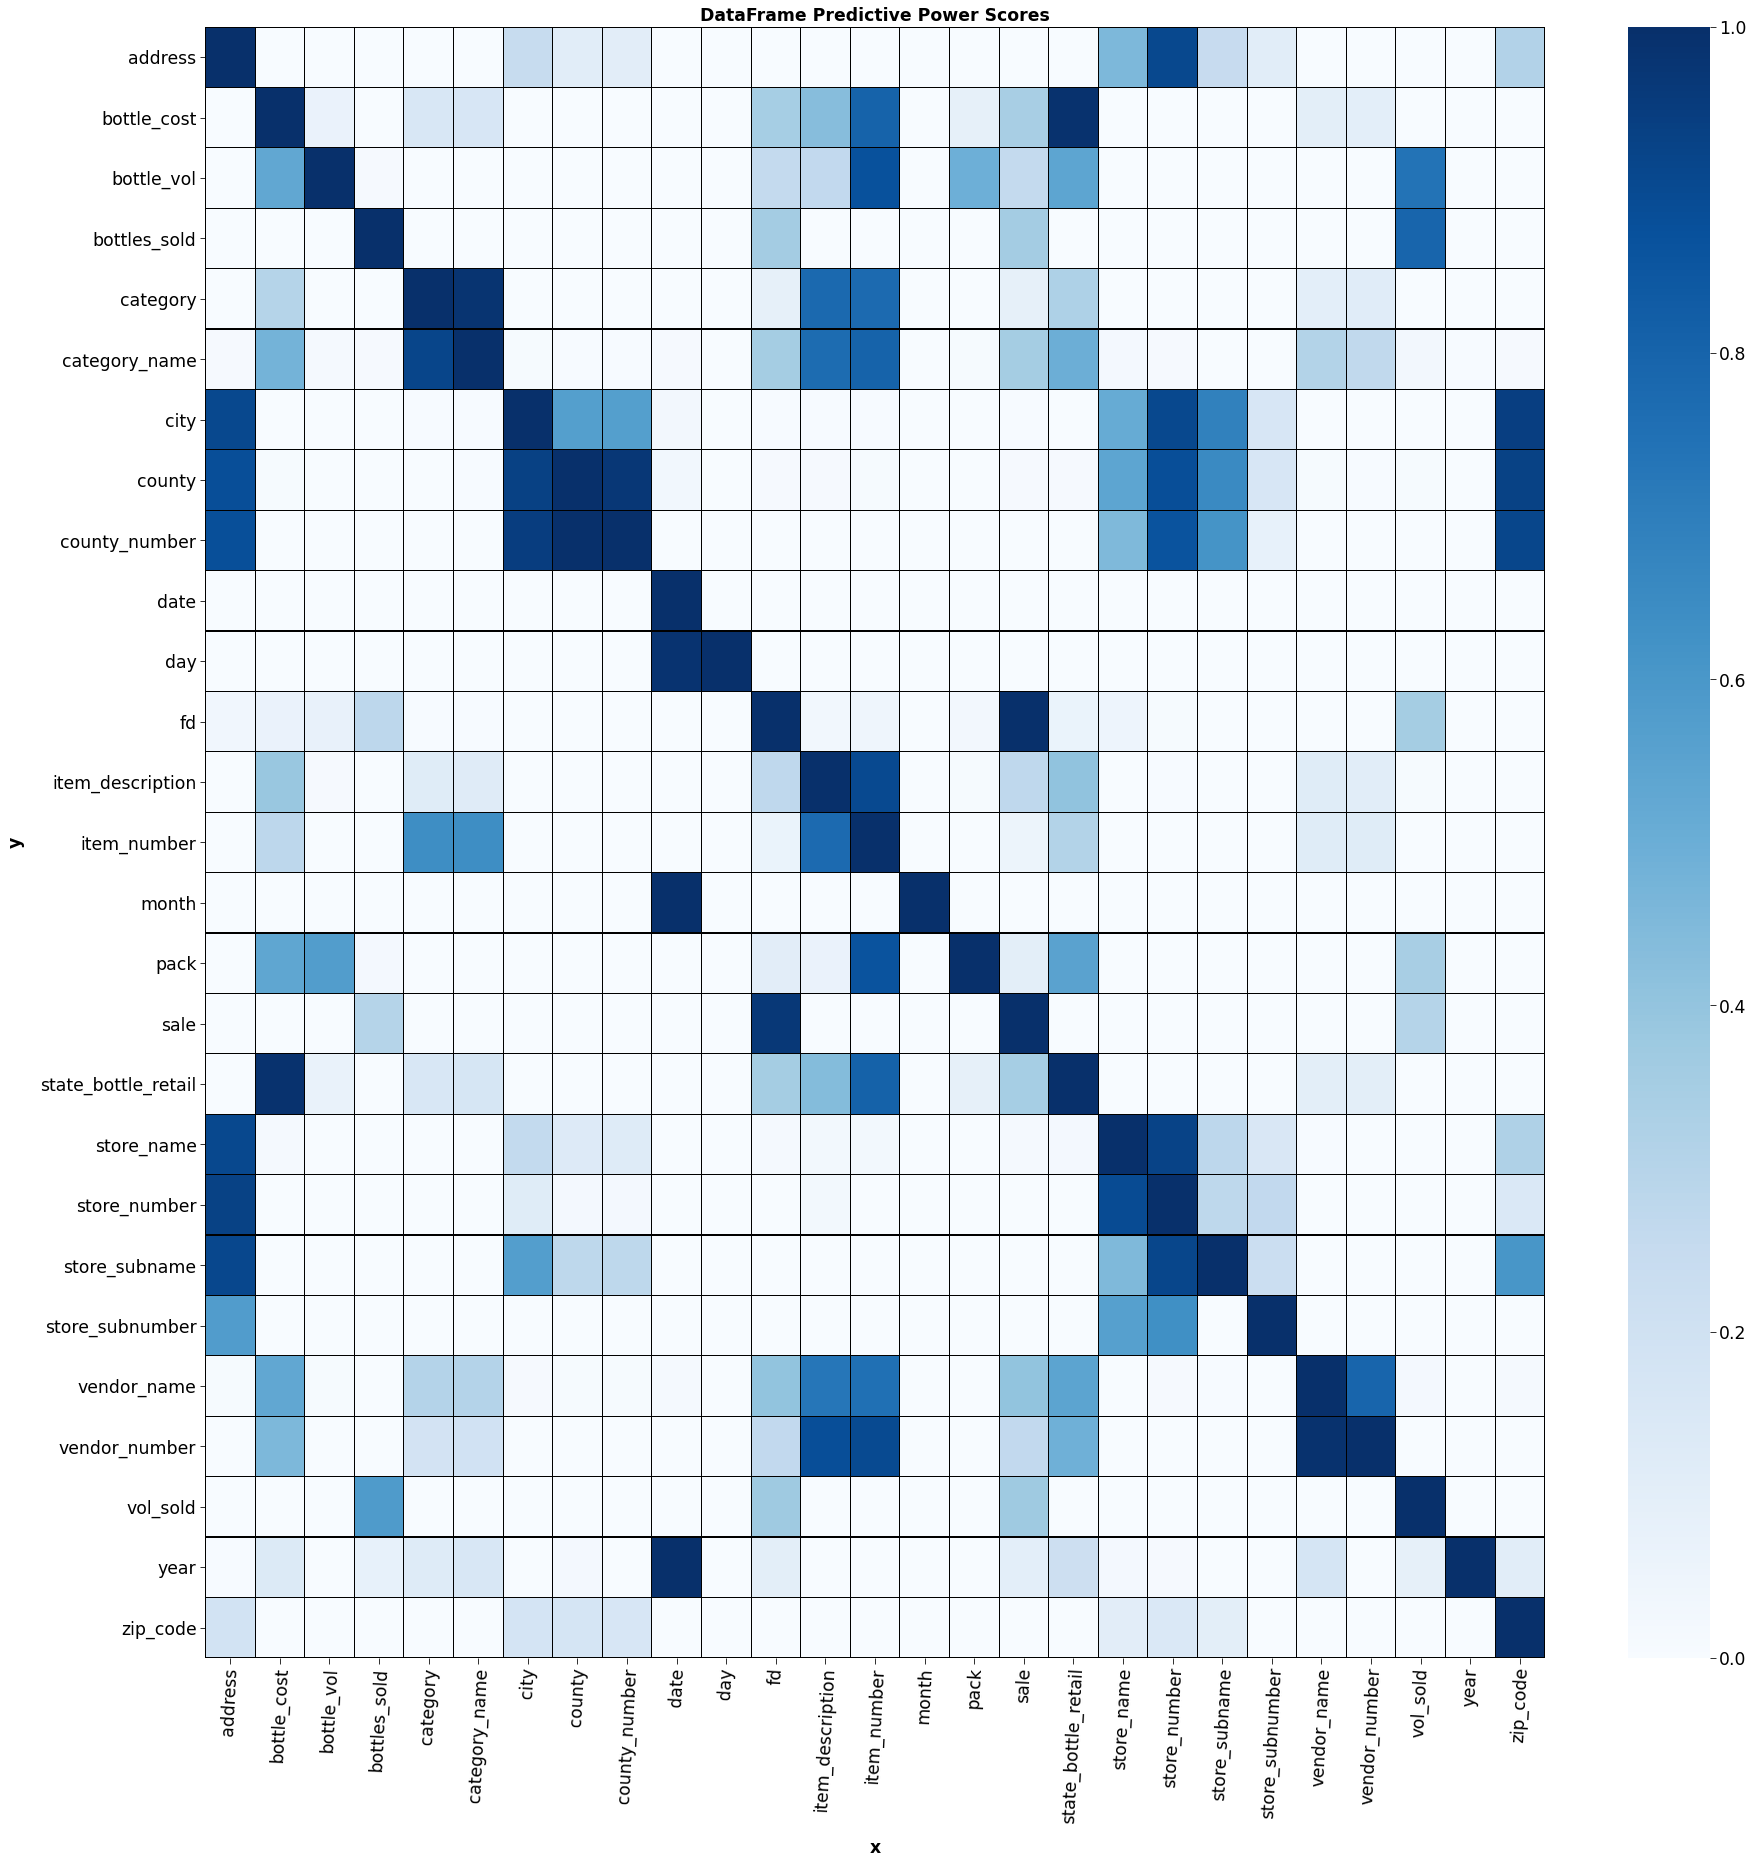

In [68]:
_ = plt.figure(figsize=(30, 30))
_ = sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.1, linecolor='k')
_ = plt.title('DataFrame Predictive Power Scores')
_ = plt.xticks(rotation=87)

### What a heatmap! Let's relay our information about the factors that scored high for predicting the sale price and amount of bottles sold in a more clear manner.

In [80]:
df_pps = pps.matrix(df)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.8/site-packages/s

#### Sale amount (total profit): what predicts sales? Vice-versa?

In [90]:
df_pps.query('y == "sale" & ppscore > 0.1').sort_values(by=['ppscore'],ascending=False)#[2:]

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
616,sale,sale,1.000000,predict_itself,True,None,0.000000,1.000000,None
643,fd,sale,0.968598,regression,True,mean absolute error,89.076022,2.797130,DecisionTreeRegressor()
589,bottles_sold,sale,0.304367,regression,True,mean absolute error,89.076022,61.964185,DecisionTreeRegressor()
670,vol_sold,sale,0.303635,regression,True,mean absolute error,89.076022,62.029408,DecisionTreeRegressor()


In [89]:
df_pps.query('x == "sale" & ppscore > 0.1').sort_values(by=['ppscore'],ascending=False)#[2:]

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
616,sale,sale,1.000000,predict_itself,True,None,0.000000,1.000000,None
617,sale,fd,0.998793,regression,True,mean absolute error,0.992467,0.001198,DecisionTreeRegressor()
608,sale,vendor_name,0.404437,classification,True,weighted F1,0.062200,0.441481,DecisionTreeClassifier()
618,sale,vol_sold,0.372296,regression,True,mean absolute error,6.077866,3.815099,DecisionTreeRegressor()
615,sale,bottles_sold,0.357024,regression,True,mean absolute error,6.084400,3.912124,DecisionTreeRegressor()
606,sale,category_name,0.354208,classification,True,weighted F1,0.037200,0.378231,DecisionTreeClassifier()
614,sale,state_bottle_retail,0.348266,regression,True,mean absolute error,6.379798,4.157932,DecisionTreeRegressor()
613,sale,bottle_cost,0.347231,regression,True,mean absolute error,4.250058,2.774308,DecisionTreeRegressor()
610,sale,item_description,0.272389,classification,True,weighted F1,0.004800,0.275881,DecisionTreeClassifier()
607,sale,vendor_number,0.263051,regression,True,mean absolute error,114.848000,84.637165,DecisionTreeRegressor()


#### The sale column predicts many values; it has high predictive value. Only two values, however, (bottles_sold and vol_sold) significantly predict the sale amount.

In [111]:
# I downloaded the above matrix because it takes less computing power to load it than it does to perform the pps method above.
file = '/Users/charisameeker/Documents/Data/Iowa Liquor/df_pps_no_index2.csv'
df_pps = pd.read_csv(file)

In [114]:
df_pps.query('y == "bottles_sold" & ppscore > 0.1').sort_values(by=['ppscore'],ascending=False)#[2:]

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
588,bottles_sold,bottles_sold,1.000000,predict_itself,True,NaN,0.0000,1.000000,NaN
669,vol_sold,bottles_sold,0.793573,regression,True,mean absolute error,6.0844,1.255982,DecisionTreeRegressor()
642,fd,bottles_sold,0.358404,regression,True,mean absolute error,6.0844,3.903728,DecisionTreeRegressor()
615,sale,bottles_sold,0.357024,regression,True,mean absolute error,6.0844,3.912124,DecisionTreeRegressor()


In [115]:
df_pps.query('x == "bottles_sold" & ppscore > 0.1').sort_values(by=['ppscore'],ascending=False)#[2:]

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
588,bottles_sold,bottles_sold,1.000000,predict_itself,True,NaN,0.000000,1.000000,NaN
591,bottles_sold,vol_sold,0.585672,regression,True,mean absolute error,6.077866,2.518228,DecisionTreeRegressor()
589,bottles_sold,sale,0.304367,regression,True,mean absolute error,89.076022,61.964185,DecisionTreeRegressor()
590,bottles_sold,fd,0.277468,regression,True,mean absolute error,0.992467,0.717089,DecisionTreeRegressor()


#### At first glance, the predictive power of each factor seems symmetrical. Volumes sold, however, predicts how many bottles are sold better than vice-versa by about 20%.

In [116]:
df_pps.query('x == "category" & ppscore > 0.1').sort_values(by=['ppscore'],ascending=False)#[2:]

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
308,category,category,1.000000,predict_itself,True,NaN,0.000000,1.000000,NaN
309,category,category_name,0.919469,classification,True,weighted F1,0.037200,0.922465,DecisionTreeClassifier()
312,category,item_number,0.638777,regression,True,mean absolute error,20699.612000,7477.173260,DecisionTreeRegressor()
311,category,vendor_name,0.308250,classification,True,weighted F1,0.062200,0.351276,DecisionTreeClassifier()
310,category,vendor_number,0.187128,regression,True,mean absolute error,114.848000,93.356734,DecisionTreeRegressor()
317,category,state_bottle_retail,0.157368,regression,True,mean absolute error,6.379798,5.375819,DecisionTreeRegressor()
316,category,bottle_cost,0.156708,regression,True,mean absolute error,4.250058,3.584041,DecisionTreeRegressor()
298,category,year,0.125963,regression,True,mean absolute error,1.452200,1.269277,DecisionTreeRegressor()
313,category,item_description,0.120027,classification,True,weighted F1,0.004800,0.124251,DecisionTreeClassifier()


In [117]:
df_pps.query('y == "category" & ppscore > 0.1').sort_values(by=['ppscore'],ascending=False)#[2:]

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
308,category,category,1.000000,predict_itself,True,NaN,0.0000,1.000000,NaN
335,category_name,category,0.983644,regression,True,mean absolute error,25556.2734,417.993935,DecisionTreeRegressor()
443,item_description,category,0.780095,regression,True,mean absolute error,25556.2734,5619.951185,DecisionTreeRegressor()
416,item_number,category,0.774543,regression,True,mean absolute error,25556.2734,5761.834455,DecisionTreeRegressor()
551,state_bottle_retail,category,0.326778,regression,True,mean absolute error,25556.2734,17205.033700,DecisionTreeRegressor()
524,bottle_cost,category,0.300942,regression,True,mean absolute error,25556.2734,17865.326521,DecisionTreeRegressor()
362,vendor_number,category,0.113587,regression,True,mean absolute error,25556.2734,22653.421769,DecisionTreeRegressor()
389,vendor_name,category,0.100716,regression,True,mean absolute error,25556.2734,22982.351658,DecisionTreeRegressor()


#### All we learn in terms of category is the category has some predictive power (.126) as to which year it is, indicating some trend in category popularity.

In [120]:
df_pps.query('x == "vendor_name" & ppscore > 0.1').sort_values(by=['ppscore'],ascending=False)#[2:]

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
392,vendor_name,vendor_name,1.000000,predict_itself,True,NaN,0.000000,1.000000,NaN
391,vendor_name,vendor_number,0.991209,regression,True,mean absolute error,114.848000,1.009600,DecisionTreeRegressor()
390,vendor_name,category_name,0.310578,classification,True,weighted F1,0.037200,0.336224,DecisionTreeClassifier()
379,vendor_name,year,0.174095,regression,True,mean absolute error,1.452200,1.199379,DecisionTreeRegressor()
393,vendor_name,item_number,0.118114,regression,True,mean absolute error,20699.612000,18254.690364,DecisionTreeRegressor()
394,vendor_name,item_description,0.117918,classification,True,weighted F1,0.004800,0.122152,DecisionTreeClassifier()
398,vendor_name,state_bottle_retail,0.104832,regression,True,mean absolute error,6.379798,5.710990,DecisionTreeRegressor()
397,vendor_name,bottle_cost,0.104741,regression,True,mean absolute error,4.250058,3.804901,DecisionTreeRegressor()
389,vendor_name,category,0.100716,regression,True,mean absolute error,25556.273400,22982.351658,DecisionTreeRegressor()


In [121]:
df_pps.query('y == "vendor_name" & ppscore > 0.1').sort_values(by=['ppscore'],ascending=False)#[2:]

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
392,vendor_name,vendor_name,1.000000,predict_itself,True,NaN,0.0000,1.000000,NaN
365,vendor_number,vendor_name,0.796459,classification,True,weighted F1,0.0622,0.809119,DecisionTreeClassifier()
419,item_number,vendor_name,0.752933,classification,True,weighted F1,0.0622,0.768300,DecisionTreeClassifier()
446,item_description,vendor_name,0.728858,classification,True,weighted F1,0.0622,0.745723,DecisionTreeClassifier()
554,state_bottle_retail,vendor_name,0.543430,classification,True,weighted F1,0.0622,0.571829,DecisionTreeClassifier()
527,bottle_cost,vendor_name,0.530910,classification,True,weighted F1,0.0622,0.560087,DecisionTreeClassifier()
608,sale,vendor_name,0.404437,classification,True,weighted F1,0.0622,0.441481,DecisionTreeClassifier()
635,fd,vendor_name,0.403822,classification,True,weighted F1,0.0622,0.440905,DecisionTreeClassifier()
311,category,vendor_name,0.308250,classification,True,weighted F1,0.0622,0.351276,DecisionTreeClassifier()
338,category_name,vendor_name,0.307937,classification,True,weighted F1,0.0622,0.350983,DecisionTreeClassifier()


#### The vendor name is somewhat predicted by the year (.174), again indicating some trending popularity in categories (and so vendors). <br>
#### Interestingly, the state bottle retail has some more predictive power than the actual sale, which means some customers may be getting good or bad deals. It is surprising that the category does not have more predictive power for the vendor variable.

In [129]:
file = '/Users/charisameeker/Documents/Data/iowa_liquor_clean3.pkl'
df.to_pickle(file)